

```
Using PINN to solve the Legendre's differential Equation and had verified for k=1,2,3,4,5 and further testing it to get good results.
```





```
Made this perfect model but overfitting model and will work as not ginig data on the flow but try to look at the below suggestions if possible:
```





```
Your implementation of a Physics-Informed Neural Network (PINN) to solve Legendre's differential equation is a solid start. Below are several points to consider regarding the model's effectiveness and areas for potential improvement.

### Key Components of Your Model
1. **Model Architecture**:
   - You are using a neural network with three hidden layers of 64 neurons each, which is reasonable for capturing complex functions like Legendre polynomials.
   - The use of `tanh` activation functions is appropriate for problems where the output can vary between negative and positive values.

2. **Initializations**:
   - The `GlorotNormal` initializer is a good choice, as it helps prevent vanishing/exploding gradients during training.

3. **Loss Function**:
   - Your combined loss function includes both the equation loss (to satisfy the Legendre differential equation) and the boundary condition loss, which is critical for training PINNs effectively.
   - Scaling the equation loss by a factor (0.1) can be helpful, but you might need to adjust this factor based on your observations during training.

4. **Training Data**:
   - You use 2000 points sampled uniformly from the interval [-1, 1] during each training step, which is generally sufficient for approximating a function.

5. **Training Epochs**:
   - You set a high number of epochs (20,000), which can help achieve convergence but may lead to overfitting if the model starts memorizing the training data instead of generalizing.

### Evaluation Metrics
- You are calculating the Mean Squared Error (MSE) between the predictions from the PINN and the true Legendre polynomial values. This is a good metric to evaluate the model's performance quantitatively.

### Plotting
- Plotting both the PINN predictions and the true Legendre polynomial provides a visual comparison that can be very informative.

### Suggestions for Improvement
1. **Regularization**: To prevent overfitting, you might consider adding dropout layers or L2 regularization.
2. **Learning Rate**: The learning rate might need tuning. Consider using a learning rate scheduler or testing different values.
3. **Increase Data Diversity**: While 2000 samples are good, ensure they cover the relevant regions well, especially near boundaries.
4. **Adaptive Loss Weights**: Experiment with adaptive weights for the loss components, dynamically adjusting based on training progress.
5. **Evaluate More Metrics**: Besides MSE, consider using other metrics like R-squared or visual inspection of residuals to assess fit quality.
6. **Batch Training**: Instead of randomly sampling the entire range each epoch, consider mini-batching to provide the model with more generalized training data.

### Conclusion
Overall, your model is well-structured, and with some tuning and adjustments, it should perform well in approximating Legendre polynomials. The effectiveness of this model will ultimately depend on how it generalizes to different orders of Legendre polynomials, so it might be worth testing with various \( k \) values to see how well the PINN adapts.

The mean squared error and visual comparisons in your results will give you a good indication of how well the model is performing, and further adjustments can help refine it even more.
```



Epoch 0, Loss: 2.0129928588867188
Epoch 500, Loss: 0.8501912355422974
Epoch 1000, Loss: 0.8406701683998108
Epoch 1500, Loss: 0.8199676275253296
Epoch 2000, Loss: 0.82518070936203
Epoch 2500, Loss: 0.821927011013031
Epoch 3000, Loss: 0.8319792747497559
Epoch 3500, Loss: 0.8295259475708008
Epoch 4000, Loss: 0.8194795846939087
Epoch 4500, Loss: 0.8186265230178833
Epoch 5000, Loss: 0.8156222105026245
Epoch 5500, Loss: 0.8146799802780151
Epoch 6000, Loss: 0.8152759075164795
Epoch 6500, Loss: 0.8097355365753174
Epoch 7000, Loss: 0.8207131028175354
Epoch 7500, Loss: 0.8193904757499695
Epoch 8000, Loss: 0.8053171634674072
Epoch 8500, Loss: 0.8121429085731506
Epoch 9000, Loss: 0.7954944968223572
Epoch 9500, Loss: 0.7911527752876282
Epoch 10000, Loss: 0.6643650531768799
Epoch 10500, Loss: 0.17330336570739746
Epoch 11000, Loss: 0.11644786596298218
Epoch 11500, Loss: 0.0956878513097763
Epoch 12000, Loss: 0.0839618667960167
Epoch 12500, Loss: 0.08537136018276215
Epoch 13000, Loss: 0.054078534245491

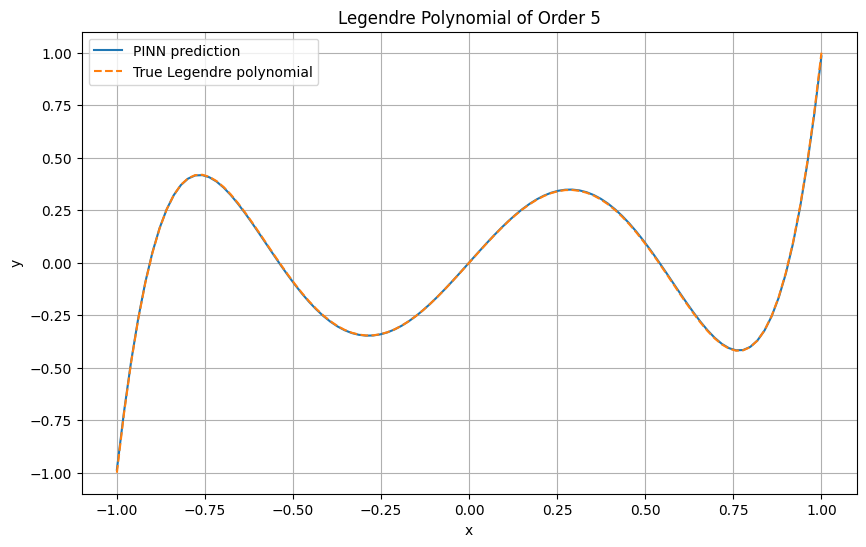

Mean Squared Error: 1.3221719572327893e-05


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class PINN:
    def __init__(self, k):
        self.k = k
        self.model = self.build_model()

    def build_model(self):
        initializer = tf.keras.initializers.GlorotNormal()
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='tanh', input_shape=(1,), kernel_initializer=initializer),
            tf.keras.layers.Dense(64, activation='tanh', kernel_initializer=initializer),
            tf.keras.layers.Dense(64, activation='tanh', kernel_initializer=initializer),
            tf.keras.layers.Dense(1, kernel_initializer=initializer)
        ])
        return model

    def legendre_equation(self, x, y, dy_dx, d2y_dx2):
        return (1 - x**2) * d2y_dx2 - 2 * x * dy_dx + self.k * (self.k + 1) * y

    def boundary_values(self):
        if self.k % 2 == 0:  # even k
            return 1.0, 1.0  # y(-1) = 1, y(1) = 1
        else:  # odd k
            return -1.0, 1.0  # y(-1) = -1, y(1) = 1

    def custom_mse(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    def loss(self, x):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y = self.model(x)
            dy_dx = tape.gradient(y, x)
        d2y_dx2 = tape.gradient(dy_dx, x)

        # Equation loss
        eq_residual = self.legendre_equation(x, y, dy_dx, d2y_dx2)
        eq_loss = 0.1 * self.custom_mse(tf.zeros_like(eq_residual), eq_residual)

        # Boundary condition loss
        y_minus_1, y_plus_1 = self.boundary_values()
        bc_pred = tf.concat([self.model(tf.constant([[-1.]])), self.model(tf.constant([[1.]]))], axis=0)
        bc_true = tf.constant([[y_minus_1], [y_plus_1]], dtype=tf.float32)
        bc_loss = self.custom_mse(bc_true, bc_pred)

        return eq_loss + bc_loss

    def train(self, epochs=20000):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        @tf.function
        def train_step():
            x = tf.random.uniform((2000, 1), -1, 1)
            with tf.GradientTape() as tape:
                loss_value = self.loss(x)
            gradients = tape.gradient(loss_value, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            return loss_value

        for epoch in range(epochs):
            loss = train_step()
            if epoch % 500 == 0:
                print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    def predict(self, x):
        return self.model(x).numpy()

def legendre_polynomial(n, x):
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x
    else:
        return ((2*n-1)*x*legendre_polynomial(n-1,x)-(n-1)*legendre_polynomial(n-2,x))/n

# Example usage
k = 5  # Order of Legendre polynomial
pinn = PINN(k)
pinn.train()

# Generate predictions
x = np.linspace(-1, 1, 100).reshape(-1, 1)
y_pred = pinn.predict(x)
y_true = legendre_polynomial(k, x)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y_pred, label='PINN prediction')
plt.plot(x, y_true, label='True Legendre polynomial', linestyle='--')
plt.title(f"Legendre Polynomial of Order {k}")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Squared Error: {np.mean((y_pred - y_true)**2)}")

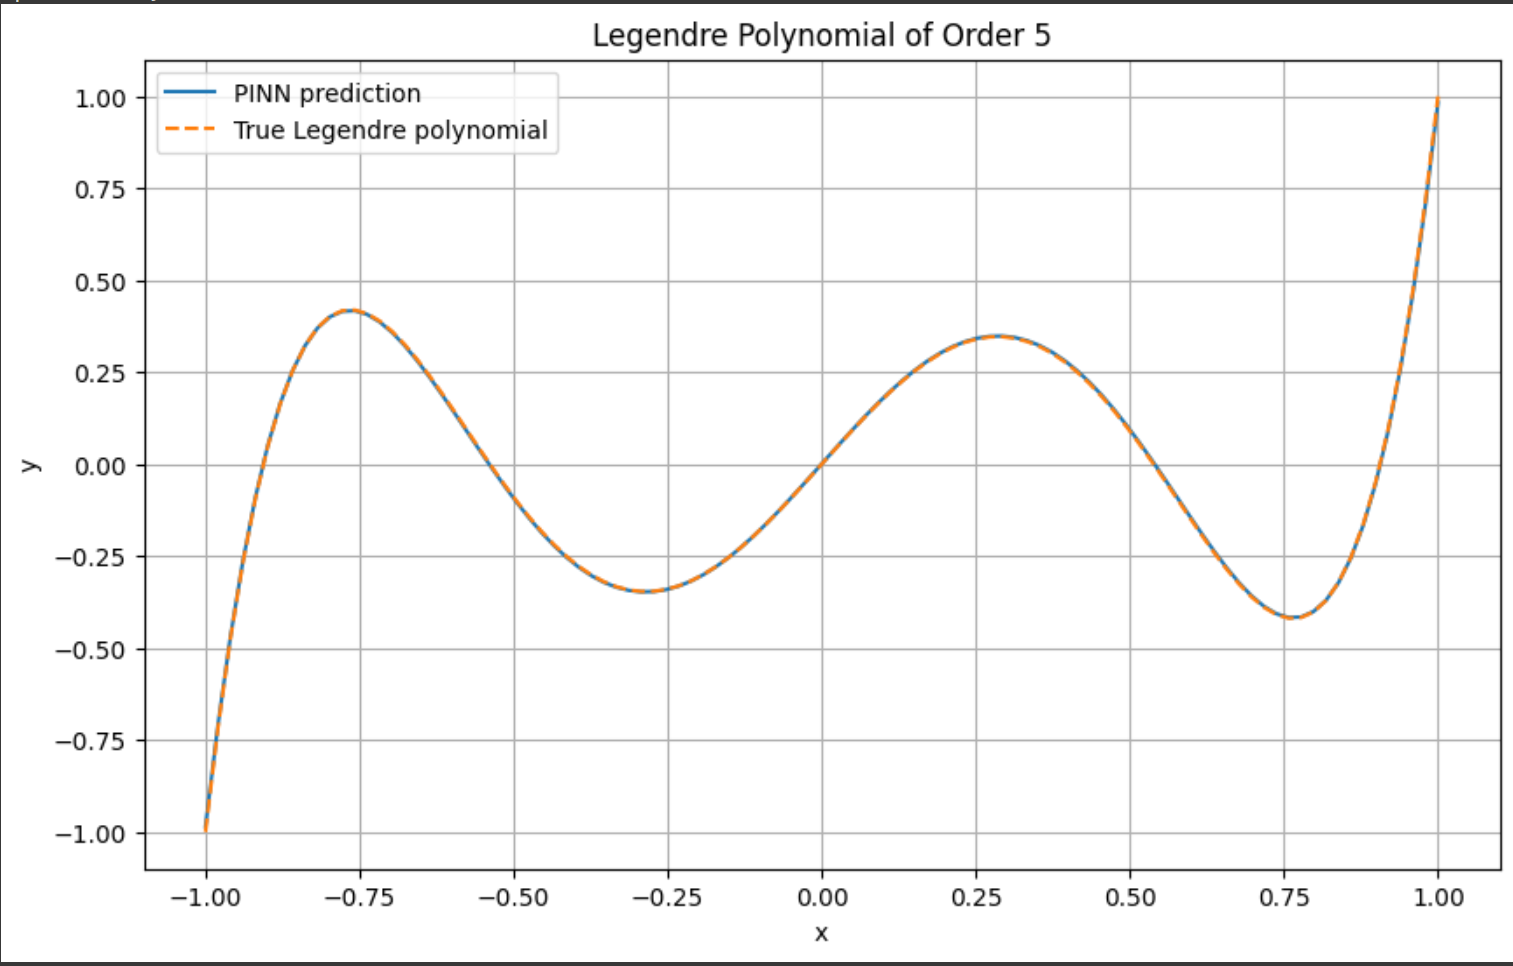